In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

def create_gender_boxplots():

    for i in range (3):
        
        if i== 0:
            test_type= "ANS"
            csv_file= "ans data.csv"
            correct_answers= "Correct response"
            
        elif i== 1:
            test_type= "Maths"
            csv_file= "maths data.csv"
            correct_answers= "correct_answers"

        elif i== 2:
            test_type= "Memory"
            csv_file= "memory data.csv"
            correct_answers= "n_correct_answers"

        # Data is sorted.
        dataframe= pd.read_csv(csv_file)    
        dataframe_sorted= dataframe.sort_values("gender", ascending= True)
        female_dataframe= dataframe_sorted[dataframe_sorted["gender"]== "f"]
        male_dataframe= dataframe_sorted[dataframe_sorted["gender"]== "m"]

        # Graph is plotted.
        fig, ax= plt.subplots()
        ax.boxplot([female_dataframe[correct_answers], male_dataframe[correct_answers]])
        ax.set_xlabel("Gender")
        ax.set_ylabel(f"Number of Correct Answers in {test_type} Test")
        ax.set_xticklabels(["Female", "Male"])
        ax.set_title(f"Spread of Correct Answers of Male and Female {test_type} Test Takers")
        plt.show()    
   
def t_test_between_genders():
    
    t_test_table= {
        "Test": [],
        "Mean score male": [],
        "Male standard error": [],
        "Mean score female": [],
        "Female standard error": [],
        "Difference in score": [],
        "P value": []
    }
    
    for i in range (3):
        
        if i== 0:
            test_type= "ANS"
            csv_file= "ans data.csv"
            correct_answers= "Correct response"
            
        elif i== 1:
            test_type= "Maths"
            csv_file= "maths data.csv"
            correct_answers= "correct_answers"

        elif i== 2:
            test_type= "Memory"
            csv_file= "memory data.csv"
            correct_answers= "n_correct_answers"
            
        # Layout is similar to the above function.
        dataframe= pd.read_csv(csv_file)    
        dataframe_sorted= dataframe.sort_values("gender", ascending= True)
        female_dataframe= dataframe_sorted[dataframe_sorted["gender"]== "f"]
        male_dataframe= dataframe_sorted[dataframe_sorted["gender"]== "m"]

        female_mean= female_dataframe[correct_answers].mean()
        male_mean= male_dataframe[correct_answers].mean()
        difference= female_mean- male_mean
        female_se= stats.sem(female_dataframe[correct_answers])
        male_se= stats.sem(male_dataframe[correct_answers])
        t_test= stats.ttest_ind(female_dataframe[correct_answers].values, male_dataframe[correct_answers].values)
        print(f"{test_type} Test p value is {t_test.pvalue}.")
    
        if t_test.pvalue<= 0.05:
            print("Result is significant a the 0.05 level.")
        
        else:
            print("The result is not significant and we fail to detect a difference in means at the 0.05 level.")

        # Table for t-test information is made.
        t_test_table["Test"].append(test_type)
        t_test_table["Mean score male"].append(male_mean)
        t_test_table["Male standard error"].append(male_se)
        t_test_table["Mean score female"].append(female_mean)
        t_test_table["Female standard error"].append(female_se)
        t_test_table["Difference in score"].append(difference)
        t_test_table["P value"].append(t_test.pvalue)
        t_test_table_df= pd.DataFrame(t_test_table)
        final_table= t_test_table_df.pivot_table(values= ["Mean score male", "Male standard error", "Mean score female", "Female standard error", "Difference in score", "P value"], index= "Test")
            
        # Dot plot for t-test is created.        
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(female_dataframe["gender"], female_dataframe[correct_answers], "o", alpha= 0.3, color= "red")
        ax.plot(male_dataframe["gender"], male_dataframe[correct_answers], "o", alpha= 0.3, color= "blue")
        ax.errorbar("f", female_mean,  yerr= female_se,  marker= "_",  color= "black")
        ax.errorbar("m", male_mean,  yerr= male_se,  marker= "_",  color= "black")
        ax.set_xlim(-1, 2)
        ax.set_ylabel("Number of correct answers")
        ax.set_xlabel("Gender")
        ax.set_title(f"Number of Correct Answers in {test_type} Test of Males vs Females")
        plt.show()
        if i==2:
            display(final_table)

def t_test_odd_even():

    for i in range (1):
        
        if i== 1:
            test_type= "ANS"
            csv_file= "ans data.csv"
            
        elif i== 0:
            test_type= "Maths"
            csv_file= "more maths data.csv"

        elif i== 2:
            test_type= "Memory"
            csv_file= "memory data.csv"

    dataframe= pd.read_csv(csv_file)
    empty_ia = pd.DataFrame()
    empty_ia["question_number"]= ""
    
    for i in range (4):
        individual_answers= dataframe.iloc[i ,5]
        ia= pd.read_json(individual_answers)
        empty_ia[i]= ia["correct_answer"] 
    
    for i in range(15):
        empty_ia.loc[i, "question_number"]= i+1
        
    empty_ia= empty_ia.sort_values("question_number")
    empty_ia= empty_ia.set_index("question_number")
    empty_ia_columns= [dataframe.iloc[0,1], dataframe.iloc[1,1], dataframe.iloc[2,1], dataframe.iloc[3,1]]
    empty_ia.columns= empty_ia_columns
    odd_questions= pd.DataFrame()
    even_questions= pd.DataFrame()
    all_answers= [even_questions, odd_questions]

    for i in range(15):
        
        if i% 2== 0:
            even_questions= pd.concat([even_questions, empty_ia.iloc[i-1:i]])

        else:
            odd_questions= pd.concat([odd_questions, empty_ia.iloc[i-1:i]])

    odd_questions["correct_answers_per_question"]= odd_questions[empty_ia_columns].sum(axis= 1)
    sum_odd= odd_questions["correct_answers_per_question"].sum()
    even_questions["correct_answers_per_question"]= even_questions[empty_ia_columns].sum(axis= 1)
    sum_even= even_questions["correct_answers_per_question"].sum()
    mean_odd= sum_odd/ 4
    mean_even= sum_even/ 4
    print(mean_odd)
    print(mean_even)
    t_test= stats.ttest_ind(sum_odd, sum_even)
    
    if t_test.pvalue<= 0.05:
        print("Result is significant a the 0.05 level.")
        
    else:
        print("The result is not significant and we fail to detect a difference in means at the 0.05 level.")
    
t_test_odd_even()

5.75
6.25
The result is not significant and we fail to detect a difference in means at the 0.05 level.


C:\Users\taoyu\AppData\Local\Temp\ipykernel_18092\2604482662.py:167: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test= stats.ttest_ind(sum_odd, sum_even)
C:\Users\taoyu\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\taoyu\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


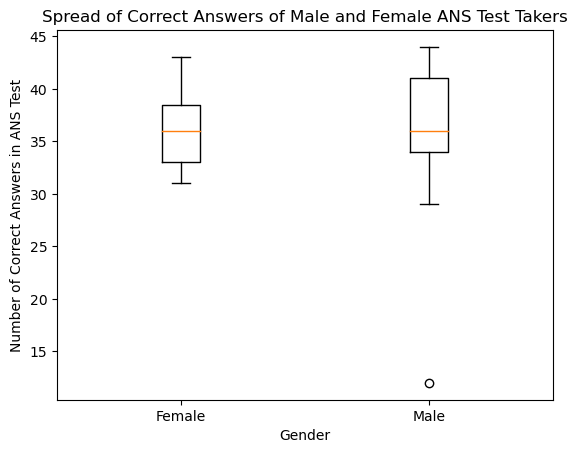

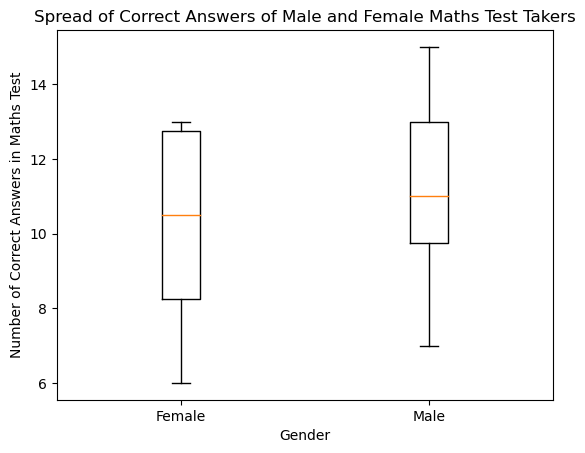

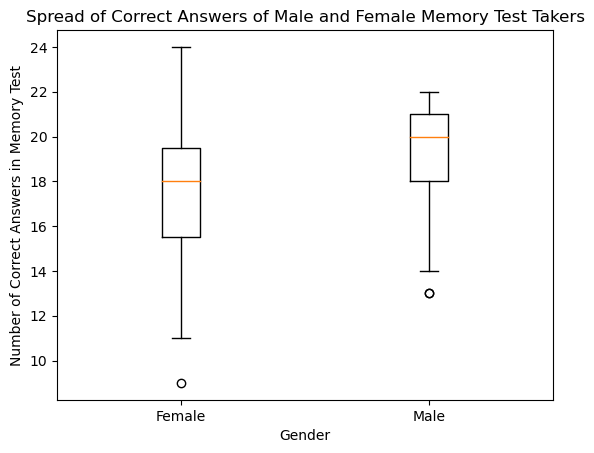

In [2]:
create_gender_boxplots()

ANS Test p value is 0.9315491487085484.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


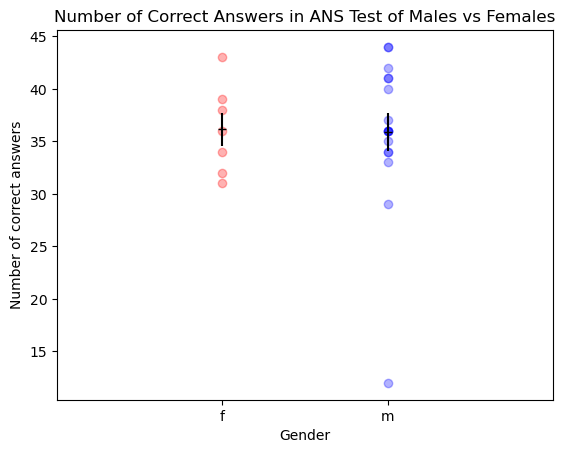

Maths Test p value is 0.20916977719163984.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


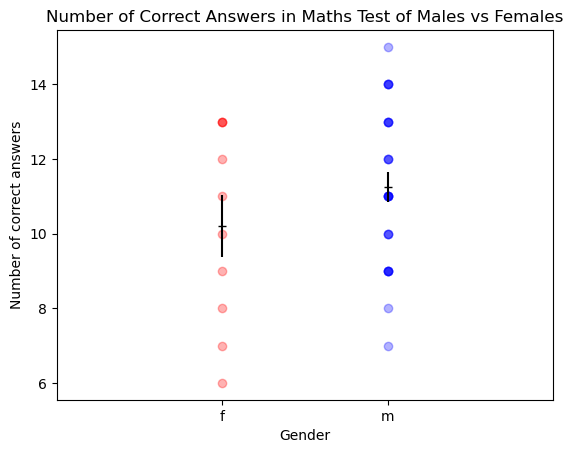

Memory Test p value is 0.2353371224457307.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


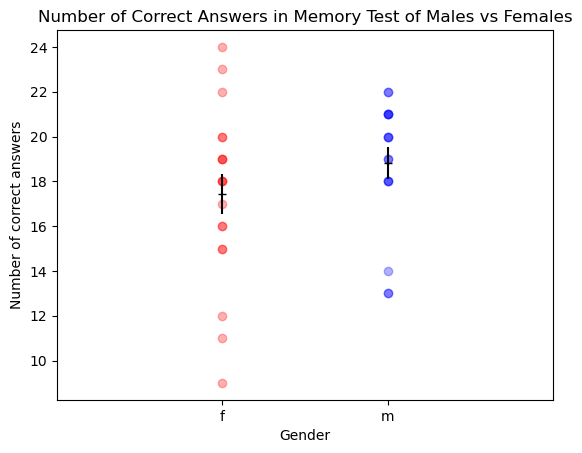

,Difference in score,Female standard error,Male standard error,Mean score female,Mean score male,P value
Test,,,,,,
ANS,0.260504,1.595060,1.792309,36.142857,35.882353,0.931549
Maths,-1.050000,0.827312,0.393818,10.200000,11.250000,0.209170
Memory,-1.402477,0.896112,0.708329,17.421053,18.823529,0.235337


In [3]:
t_test_between_genders()

In [ ]:
for answers in all_answers:
    answers["correct_answers_per_question"]= answers['ZZLX', 'ABCD', 'AAAA', 'Haiton'].sum(axis= 1)
    answers["total_correct_answers"]= answers["correct_answers_per_questions"].sum(axis= 1)
    for i range (4):
        answers[i]= answers[
display(even_questions)
display(odd_questions)
display(empty_ia)
categories= ["Odd questions", "Even questions"]
means= [mean_odd, mean_even]
plt.bar(categories, means)
plt.show()